In [ ]:
!pip install -q langchain_openai langchain_community langchainhub langchain langgraph

In [ ]:
!pip install -q tiktoken chromadb pypdf tavily-python

In [ ]:
!pip install -q python-dotenv # .env file load

In [ ]:
# Google Drive Connect
from google. colab import drive
drive. mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %cd /content/drive/MyDrive/RAG
!ls -a
# !pwd

.  ..  .config	drive  sample_data


In [ ]:
# api key 現在のディレクトリの.envに中身が登録されているかを確認
from dotenv import load_dotenv # Add
load_dotenv() # load .env

False

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI
import os
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')


llm = ChatOpenAI (model ="gpt-4o-mini", temperature=0)
openai_embed_model = OpenAIEmbeddings(model ='text-embedding-3-small')

In [ ]:
from langchain.document_loaders import PyPDFLoader
loader = PyPDFLoader("/content/drive/MyDrive/RAGlib.pdf")
docs = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=30)
chunked_docs = text_splitter.split_documents (docs)
chunked_docs [:2]
# ドキュメントの前から二つ分の要素の確認

[Document(metadata={'source': '/content/drive/MyDrive/RAGlib.pdf', 'page': 0, 'page_label': '1'}, page_content='* Corresponding Author: Cheonsu Jeong; paripal@korea.ac.kr \n \n  \n1  \n \n \nA Study on the Implementation Method \nof an Agent-Based Advanced RAG  \nSystem Using Graph \nCheonsu Jeong1 \n \n \n \n1 Dr. Jeong is Principal Consultant & the Technical Leader for AI Automation at SAMSUNG SDS; \n \nAbstract'),
 Document(metadata={'source': '/content/drive/MyDrive/RAGlib.pdf', 'page': 0, 'page_label': '1'}, page_content='Abstract  \nThis study aims to improve knowledge-based question-answering (QA) systems by overcoming the limitations of \nexisting Retrieval-Augmented Generation (RAG) models and implementing an advanced RAG system based on')]

In [ ]:
# Load the documents to vectorstore
vectorstore = Chroma.from_documents(documents=chunked_docs, collection_name="rag_pdf_db", embedding=openai_embed_model)
retriever = vectorstore.as_retriever ()
print(retriever)
# retrieverという名の検索できるデータベース

tags=['Chroma', 'OpenAIEmbeddings'] vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x7a7f89b12710> search_kwargs={}


In [ ]:
### Implement the Retrieval Grader
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

# Data model for LLM output format
class GradeDocuments(BaseModel):
    """A binary score for checking relevance of retrieved documents."""
    binary_score: str = Field(description="Rates whether the document is relevant to the question with a 'yes' or 'no'")

# LLM for grading
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)
# print(structured_llm_grader)
# Prompt template for grading
SYS_PROMPT = """You are a professional evaluator who evaluates the relevance of searched documents.
- We assign a relevance rating to documents if they contain keywords or semantically related content to the user's question.
- Your rating should be 'yes' or 'no' indicating whether the article is relevant to the user's question."""

grade_prompt = ChatPromptTemplate.from_messages([
    ("system", SYS_PROMPT),
    ("human", """Searched Documents: {document}
User Questions: {question}""")
])

# Build grader chain
doc_grader = (grade_prompt | structured_llm_grader)
print(doc_grader)


first=ChatPromptTemplate(input_variables=['document', 'question'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template="You are a professional evaluator who evaluates the relevance of searched documents.\n- We assign a relevance rating to documents if they contain keywords or semantically related content to the user's question.\n- Your rating should be 'yes' or 'no' indicating whether the article is relevant to the user's question."), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['document', 'question'], input_types={}, partial_variables={}, template='Searched Documents: {document}\nUser Questions: {question}'), additional_kwargs={})]) middle=[RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7a7f8e8001d0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7

/usr/local/lib/python3.11/dist-packages/langchain_openai/chat_models/base.py:1363: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


In [ ]:
query = "Is the LangGraphbased system optimized for specific domains?"

topk_docs = retriever.invoke(query)
# print(topk_docs)
for doc in topk_docs:
  print(doc.page_content)
  print("================================")
  print('GRADE:', doc_grader.invoke({"question": query,
  "document": doc.page_content}))
  print ("================================")

# 質問文でベクトルデータベースに検索をかけて類似度の評価

suitable for internal corporate use. The implementation 
approach and considerations for using LangGraph, which 
is well -suited for Agent implementation, are demon-
strated through practical examples. 
4.1. Development Environment 
The solutions and development platforms applied in this
GRADE: binary_score='no'
suitable for internal corporate use. The implementation 
approach and considerations for using LangGraph, which 
is well -suited for Agent implementation, are demon-
strated through practical examples. 
4.1. Development Environment 
The solutions and development platforms applied in this
GRADE: binary_score='no'
cial foundation for the advancement of RAG -based gen-
erative AI services. 
However, several limitations remain. The LangGraph -
based system is optimized for specific domains, which 
may result in performance degradation when applied to 
other fields. Additionally, the system's complexity may
GRADE: binary_score='yes'
cial foundation for the advancement of RAG -based 

In [ ]:
# query = "Tell me what is the capital of the country where ohtani shohei is?"

# topk_docs = retriever.invoke(query)
# # print(topk_docs)
# for doc in topk_docs:
#   print(doc.page_content)
#   print("================================")
#   print('GRADE:', doc_grader.invoke({"question": query,
#   "document": doc.page_content}))
#   print ("================================")


In [ ]:

from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

# RAG prompt for generating answer
prompt = """You are an Assistant for a Q&A.
Answer the question using the following retrieved Context fragment.
If there is no context or you do not know the answer, answer that you do not know the answer.
Do not construct an answer unless it corresponds to the provided Context.
If the Context value is null when constructing an answer, answer 'RAG does not have relevant information'.
Please provide a detailed and summarized answer to the question.

Question: {question}
Context: {context}
Answer:
"""

prompt_template = ChatPromptTemplate.from_template(prompt)

# Initialize GPT-4-turbo connection
llm = ChatOpenAI(model_name='gpt-4o-mini', temperature=0)

# Used to separate context documents on a new line
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Create QA RAG chain
qa_rag_chain = (
    {
        "context": (itemgetter('context') | RunnableLambda(format_docs)),
        "question": itemgetter('question')
    }
    | prompt_template
    | llm
    | StrOutputParser()
)
print(qa_rag_chain)

first={
  context: RunnableLambda(itemgetter('context'))
           | RunnableLambda(format_docs),
  question: RunnableLambda(itemgetter('question'))
} middle=[ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an Assistant for a Q&A.\nAnswer the question using the following retrieved Context fragment.\nIf there is no context or you do not know the answer, answer that you do not know the answer.\nDo not construct an answer unless it corresponds to the provided Context.\nIf the Context value is null when constructing an answer, answer 'RAG does not have relevant information'.\nPlease provide a detailed and summarized answer to the question.\n\nQuestion: {question}\nContext: {context}\nAnswer:\n"), additional_kwargs={})]), ChatOpenAI(client=<openai.resources.chat.completions.Completions o

In [ ]:
query = "Is the LangGraphbased system optimized for specific domains?"

topk_docs = retriever.invoke(query)

result = qa_rag_chain.invoke({
    "context": topk_docs,
    "question": query
})

print(result)
# 類似度上位３つからここで実際に解答を得ている

Yes, the LangGraph-based system is optimized for specific domains. This optimization can lead to performance degradation when the system is applied to fields outside of those specific domains. Additionally, the complexity of the system may pose challenges in broader applications.


In [ ]:
query = "Tell me what is the capital of the country where ohtani shohei is?"

topk_docs = retriever.invoke(query)

result = qa_rag_chain.invoke({
    "context": topk_docs,
    "question": query
})

print(result)
# 類似度上位３つからここで実際に解答を得ている

RAG does not have relevant information.


In [ ]:
# Figure11 web検索でヒットしやすくなるように文章を変える

# Question rewriting - LLM: Rewrites entered user queries into questions optimized for web search
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Question rewriting - Prompt template
SYS_PROMPT = """Act as a question rewriter and perform the following tasks:
- Convert the following input question into a better version optimized for web search
- When rewriting, look at the input question and infer its underlying semantic intent
- Ensure the rewritten question is clear, concise, and specific
- Maintain the original meaning and intent of the question
- Use proper grammar and punctuation"""

re_write_prompt = ChatPromptTemplate.from_messages([
    ("system", SYS_PROMPT),
    ("human", """First Question:
{question}
Write improved question:""")
])

# Create a rephraser chain
question_rewriter = re_write_prompt | llm | StrOutputParser()
# print(question_rewriter)
query = "Tell me what is the capital of the country where ohtani shohei is?"
question_rewriter.invoke({"question": query})

'What is the capital of the country where Shohei Ohtani is from?'

In [ ]:
# Figure 12: Evaluation of Hallucinations
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

# プロンプトテンプレートの定義
prompt = PromptTemplate(
    template=""" This is an evaluator that evaluates whether or not a hallucination is present.
It gives a binary 'yes' or 'no' to indicate whether or not a hallucination is present
If you have hallucinations, give 'yes'.
Provide the binary score as a JSON with a
single key 'h_score' and no preamble or explanation.
Here are the facts:
Wn ------- Wn
{documents}
Wn ------- Wn
Here is the answer：{generation}
""",
    input_variables=["generation", "documents"]
)
hallucination_grader = prompt | llm | JsonOutputParser ()

# RAGチェーンの作成
# rag_chain = (
#     {
#         "context": (itemgetter('context') | RunnableLambda(format_docs)),
#         "question": itemgetter('question')
#     }
#     | prompt_template
#     | llm
#     | StrOutputParser()
# )
# print(topk_docs)

generation = qa_rag_chain.invoke({"context": topk_docs, "question": query})
print(generation)
hallucination_grader_response = hallucination_grader.invoke({"documents":topk_docs, "generation": generation})
print(hallucination_grader_response)




# Figure 13: Evaluation of Answer Relevance

# プロンプトテンプレートの定義
prompt = PromptTemplate(
    template="""You are a relevance evaluator
You connect the retrieved document to the user's question. If the document contains keywords relevant to the user's question, rate it as relevant. There is no need to be strict. The goal is to filter out bad searches.
You assign a binary score of 'yes' or 'no' to indicate whether the document is relevant to the question.
Provide the binary score as a JSON with a single key 'r_score' and no preamble or explanation.
-------
{documents}
-------
Here is the answer: {generation}""",
    input_variables=["generation", "documents"]
)


# 検索関連性評価器の作成
retrieval_grader = prompt | llm | JsonOutputParser()

# 実行例
# docs = "ここに検索された文書の内容を入れてください"
# query = "ユーザーの質問をここに入れてください"
# result = "RAGチェーンの結果をここに入れてください"
# result = qa_rag_chain.invoke({"context": topk_docs, "question": query})
# print(result)
retrieval_grader_response = retrieval_grader.invoke({"documents": topk_docs, "generation": generation})
print(retrieval_grader_response)

RAG does not have relevant information.
{'h_score': 'no'}
{'r_score': 'no'}


Definition of the Agent RAG Graph

In [ ]:
# Figure 14: Definition of Web Search Tool and Agent Graph State
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
# Webサーチツールを読み込む
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(max_results=2, search_depth='advanced', max_tokens=5000)

# グラフ状態を定義
from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
  """
  The state of the graph.
  Attributes:
  question: question
  generation: Generate LLM Answer
  web_search_add: Flag indicating whether to add web search - yes or no documents: List of context documents
  """
  question: str
  generation: str
  web_search_add: str
  documents: List[str]


In [ ]:
# Figure 15: Retrieveノードグラフの実装例
from langchain.schema import Document
def retrieve(state):
    """
    ベクトルストアからドキュメントを検索する

    Args:
        state (dict): 現在のグラフ状態

    Returns:
        dict: 検索されたドキュメントを含む新しいキーを追加した状態
    """
    print("---Search in VectorDB---")
    question = state["question"]
    # 検索を実行
    topk_documents = retriever.invoke(question)
    print(topk_documents)

    # 状態を直接更新
    state["documents"] = topk_documents

    return {"documents": topk_documents, "question":question}


In [73]:
def grade_documents(state):
    print("---Relevance Determination of Search Results---")
    question = state["question"]
    documents = state["documents"]
    graded_docs = []

    for doc in documents:
        grade = doc_grader.invoke({
            "question": question,
            "document": doc.page_content
        })
        if grade.binary_score == "yes":
            graded_docs.append({"document": doc, "relevance_grade": grade.binary_score})

    state["documents"] = graded_docs
    print(state)
    return state


In [ ]:
def rewrite_query(state):
    print("---Question Rewriting---")
    original_question = state["question"]

    # 質問書き換えチェーンを使用して質問を最適化
    rewritten_question = question_rewriter.invoke({"question": original_question})

    # 状態を更新
    state["question"] = rewritten_question

    return state


In [69]:
def web_search(state):
    print("---Web検索を実行中---")
    question = state["question"]

    # Tavily APIを使用してWeb検索を実行
    search_results = web_search_tool.invoke(question)

    # 検索結果を文字列に変換
    search_content = "\n".join([result.get("content", "") for result in search_results])

    # 状態を更新
    state["documents"] = [Document(page_content=search_content)]
    state["web_search_add"] = "yes"

    return state


In [ ]:
def generate_answer(state):
    print("---回答を生成中---")
    question = state["question"]
    documents = state["documents"]

    # ここでRAGチェーンを使用して回答を生成
    result = qa_rag_chain.invoke({
        "context": documents,
        "question": question
    })

    return {"generation": result}


In [77]:
def decide_to_generate(state):
    graded_docs = state["documents"]

    # relevance_gradeがyesの文書が1つでもあればgenerate_answerを選択
    if any(doc["relevance_grade"] == "yes" for doc in graded_docs):
        return "generate_answer"
    else:
        return "rewrite_query"


In [78]:
# Figure 16: 回答生成のためのノード定義とグラフ作成

from langgraph.graph import END, StateGraph

# グラフを初期化
workflow_agent_rag = StateGraph(GraphState)

# ノードを定義
workflow_agent_rag.add_node("retrieve", retrieve)  # 検索
workflow_agent_rag.add_node("grade_documents", grade_documents)  # ドキュメント評価
workflow_agent_rag.add_node("rewrite_query", rewrite_query)  # クエリ書き換え
workflow_agent_rag.add_node("web_search", web_search)  # Web検索
workflow_agent_rag.add_node("generate_answer", generate_answer)  # 回答生成

# # グラフを構築
workflow_agent_rag.set_entry_point("retrieve")
workflow_agent_rag.add_edge("retrieve", "grade_documents")
workflow_agent_rag.add_conditional_edges("grade_documents",decide_to_generate,
    {"rewrite_query": "rewrite_query","generate_answer": "generate_answer"},)
workflow_agent_rag.add_edge("rewrite_query", "web_search")
workflow_agent_rag.add_edge("web_search", "generate_answer")
# workflow_agent_rag.add_conditional_edges(
#     "generate_answer",
#     grade_generation_v_documents_and_question,
#     {
#         "not supported": "generate_answer",
#         "useful": END,
#         "not useful": "web_search",
#     },
# )

# グラフをコンパイル
workflow_agent_rag = workflow_agent_rag.compile()

In [80]:
initial_state = GraphState(
    question="Is the LangGraphbased system optimized for specific domains?",
    generation="",
    web_search_add="",
    documents=[]
)
result = workflow_agent_rag.invoke(initial_state)

print(result)


---Search in VectorDB---
[Document(metadata={'page': 5, 'page_label': '6', 'source': '/content/drive/MyDrive/RAGlib.pdf'}, page_content='suitable for internal corporate use. The implementation \napproach and considerations for using LangGraph, which \nis well -suited for Agent implementation, are demon-\nstrated through practical examples. \n4.1. Development Environment \nThe solutions and development platforms applied in this'), Document(metadata={'page': 5, 'page_label': '6', 'source': '/content/drive/MyDrive/RAGlib.pdf'}, page_content='suitable for internal corporate use. The implementation \napproach and considerations for using LangGraph, which \nis well -suited for Agent implementation, are demon-\nstrated through practical examples. \n4.1. Development Environment \nThe solutions and development platforms applied in this'), Document(metadata={'page': 10, 'page_label': '11', 'source': '/content/drive/MyDrive/RAGlib.pdf'}, page_content="cial foundation for the advancement of RAG -b

AttributeError: 'dict' object has no attribute 'page_content'

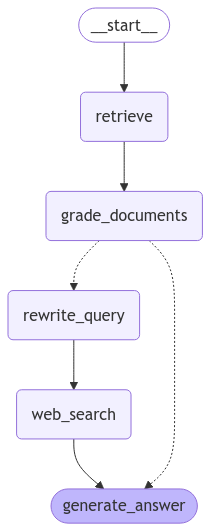

In [76]:
from IPython.display import Image, display, Markdown
display(Image(workflow_agent_rag.get_graph().draw_mermaid_png()))

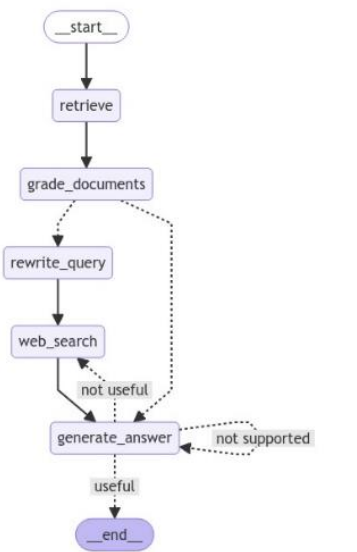